# Deploying an Image Enhancement Model with Hugging Face Inference Endpoints

In this guide, we'll see how to deploy an image upsampling model with [Hugging Face Inference Endpoints](https://huggingface.co/docs/inference-endpoints/index) 🤗. Don't have access yet? Read the instructions to sign up [here](https://huggingface.co/docs/inference-endpoints/guides/access#access-the-solution).

The model we'll be using is [Real-ESRGAN](https://github.com/xinntao/Real-ESRGAN/). It takes in an image, and upsamples it to 4x the resolution! You can imagine that models like this can be really practical, and you might want to build in this functionality into some app you're making.

By deploying a inference endpoint, we'll make the model available by API request. These endpoints scale with your usage, so they're a great choice for deploying models for your production use-cases.

Ok, let's get to it 💪

In [ ]:
%%capture
! pip install realesrgan==0.3.0
! pip install huggingface_hub

The `realesrgan` package comes with a helpful inference class, `RealESRGANer`, that we'll use to make predictions with the model. Let's start by getting it working here in Colab...

First, we'll need an example image that we want to upsample.

In [ ]:
! wget -nc https://huggingface.co/datasets/nateraw/misc/resolve/main/Group%20122.png -O hf.png

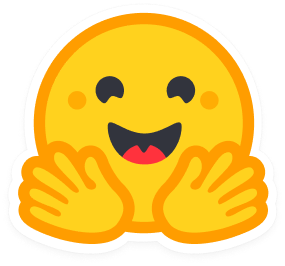

In [96]:
from PIL import Image

file_path = 'hf.png'
im = Image.open(file_path)
im

Next, we'll need the model weights. I've already uploaded the to the Hub [here](https://huggingface.co/nateraw/real-esrgan). To download them, we'll use `huggingface_hub.snapshot_download` to download the whole repo.

The reason for that (as opposed to just downloading the weights file) is that our handler will expect a root directory where the weights live, so this will mimic what will happen when the endpoint is deployed.

In [95]:
from pathlib import Path
from huggingface_hub import snapshot_download

repo_path = snapshot_download('nateraw/real-esrgan')
weights_path = str(Path(repo_path) / "RealESRGAN_x4plus.pth")
weights_path

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/1.54k [00:00<?, ?B/s]

'/root/.cache/huggingface/hub/models--nateraw--real-esrgan/snapshots/737dcbb7093ae5d4f2e44b2379d781a3f1ca30bc/RealESRGAN_x4plus.pth'

Great! Now we can initialize the model and its helper inference wrapper.

In [ ]:
import numpy as np
from basicsr.archs.rrdbnet_arch import RRDBNet
from realesrgan import RealESRGANer

model = RRDBNet(num_in_ch=3, num_out_ch=3)
upsampler = RealESRGANer(
    scale=4,
    model_path=weights_path,
    model=model,
    tile=0,
    pre_pad=0,
    half=True,
)

To do upsampling, we need to:

- convert our PIL image to numpy
- convert that image from RGB format to BGR


In [93]:
inputs = np.array(im)[:, :, ::-1]  # RGB -> BGR
output, _ = upsampler.enhance(inputs)
out_im = output[:, :, ::-1]  # BGR -> RGB
out_im = Image.fromarray(out_im)

print(f"Input Image Size: {im.size}")
print(f"Output Image Size: {out_im.size}")

Input Image Size: (285, 266)
Output Image Size: (1140, 1064)


Sweet! Now our 🤗 is HUGE :)

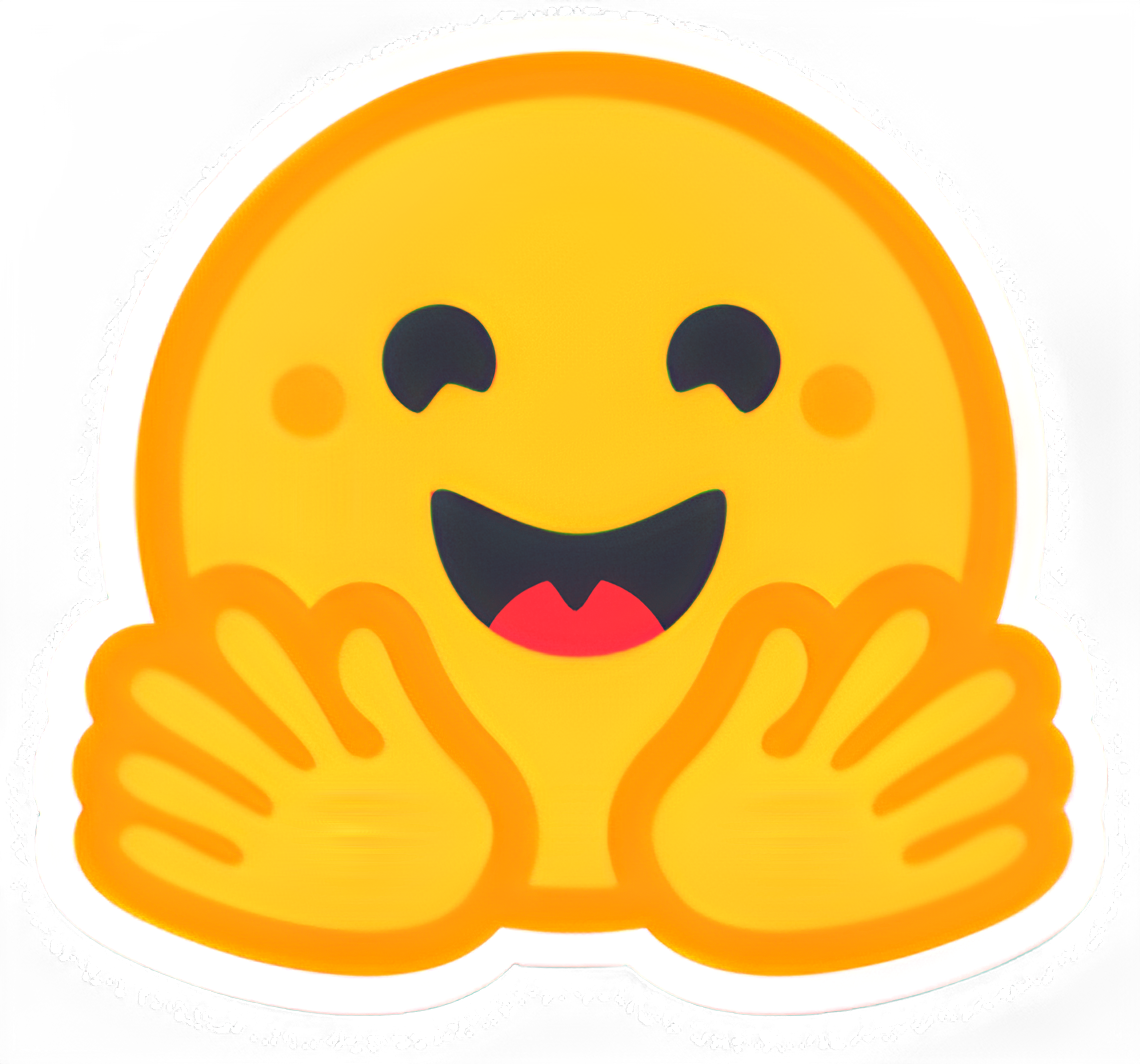

In [94]:
out_im

## Creating a Custom Inference Endpoint Handler

Now, we'll see how to write the custom inference endpoint handler. You can read more about how this works in the [docs](https://huggingface.co/docs/inference-endpoints/guides/custom_handler)!

We'll need to create a simple class called `EndpointHandler`, that has two functions:

  1. The __init__ method will be called when starting the Endpoint and will receive 1 argument, a string with the path to your model weights. This allows you to load your model correctly.
  2. The __call__ method will be called on every request and receive a dictionary with your request body as a python dictionary. It will always contain the inputs key.

In our case, our `__call__` fn will take in inputs containing our image that look like this:

```json
{
    "inputs": "<bytestring of an image>"
}
```

The output will look like this:

```json
{
    "image": "<bytestring of upsampled image>"
}
```

Here's the full code for our endpoint handler:

In [ ]:
from base64 import b64encode, b64decode
from io import BytesIO
from pathlib import Path

import numpy as np
from basicsr.archs.rrdbnet_arch import RRDBNet
from PIL import Image
from realesrgan import RealESRGANer


class EndpointHandler:
    def __init__(self, path=""):
        model = RRDBNet(num_in_ch=3, num_out_ch=3)
        self.upsampler = RealESRGANer(
            scale=4,
            model_path=str(Path(path) / "RealESRGAN_x4plus.pth"),
            model=model,
            tile=0,
            pre_pad=0,
            half=True,
        )

    def __call__(self, data):
        """
        Args:
            data (:obj:):
                includes the input data and the parameters for the inference.
        Return:
            A :obj:`dict`:. base64 encoded image
        """
        image = data.pop("inputs", data)

        # This lets us pass local images as well while developing
        if isinstance(image, str):
            image = Image.open(BytesIO(b64decode(image)))
        elif isinstance(image, bytes):
            image = Image.open(BytesIO(image))

        image = np.array(image)
        image = image[:, :, ::-1]  # RGB -> BGR
        image, _ = self.upsampler.enhance(image, outscale=4)
        image = image[:, :, ::-1]  # BGR -> RGB
        image = Image.fromarray(image)

        # Turn output image into bytestr
        buffered = BytesIO()
        image.save(buffered, format="PNG")
        img_bytes = b64encode(buffered.getvalue())
        img_str = img_bytes.decode()

        return {"image": img_str}

Most of the `__call__` function above is similar to what we did when we played with the model earlier, but note how we are converting the output to bytes now to send it back.

We use a trick to write the image bytes to a buffer, then turn that buffer into bytes, then to a string, so it is JSON serialiable.

This trick can be used for all sorts of types of data, like audio, video, etc.

```python
buffered = BytesIO()
im.save(buffered, format="PNG")
img_bytes = b64encode(buffered.getvalue())
img_str = img_bytes.decode()
```

Let's initialize this handler locally here in Colab to make sure it's working as expected.

In [92]:
handler = EndpointHandler(repo_path)

In [ ]:
out = handler({'inputs': im})
out

# {'image': '<BYTESTRING>'}

It works! We can turn that bytestring back to a `PIL.Image` like this:

In [89]:
from base64 import b64decode
from PIL import Image
from io import BytesIO

out_im = Image.open(BytesIO(b64decode(out['image'])))
out_im.size

(1140, 1064)

## Deploying the Endpoint

Now that we have this working here in Colab, let's get it deployed! 🚀

We start by navigating to the [endpoint creation page](https://ui.endpoints.huggingface.co/new).

![img](https://huggingface.co/datasets/nateraw/documentation-images/resolve/main/create_inference_endpoint.png)

Once we do this, you'll see the endpoint start to be depoloyed..

![img](https://huggingface.co/datasets/nateraw/documentation-images/resolve/main/inference_endpoint_build.png)

If all goes to plan, you should see it switch to running! :)

![img](https://huggingface.co/datasets/nateraw/documentation-images/resolve/main/inference_endpoint_running.png)

Now we can make a request! We'll need two things:

1. Your Hugging Face token, if your endpoint isn't public.
2. The endpoint URL, which you can copy from your deployment's page (seen above).

For the first one, we'll use `huggingface_hub` to grab this, but we'll need to login first here.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

<tip>

We specify `application/json` for the `Content-Type`, so we can handle encoding the input images ourselves. Otherwise, the default encoding used in the background will convert RGBA images to RGB, which will effect our results.  More information on serialization/deserializatin in HF inference endpoints can be found [in the docs](https://huggingface.co/docs/inference-endpoints/main/en/others/serialization#serialization-deserialization-for-requests).

</tip>

In [81]:
import requests
from base64 import b64decode, b64encode
from PIL import Image
from io import BytesIO

from huggingface_hub import HfFolder

endpoint_url = 'YOUR ENDPOINT HERE'

token = HfFolder().get_token()
headers = {
    'Authorization': f'Bearer {token}',
    'Content-Type': 'application/json',
}

file_path = 'hf.png'

with open(file_path, 'rb') as f:
    data = f.read()

payload = {'inputs': b64encode(data).decode()}

response = requests.post(endpoint_url, headers=headers, json=payload)
response.status_code, response.reason

(200, 'OK')

If you got a `200` status code above, then everything worked! Let's take a look at the resulting output image to be sure...

In [79]:
from base64 import b64decode
from PIL import Image
from io import BytesIO

def bytestr_to_image(bytestr):
    return 

data = response.json()
upsampled_image = Image.open(BytesIO(b64decode(data['image'])))
upsampled_image.size

(1140, 1064)

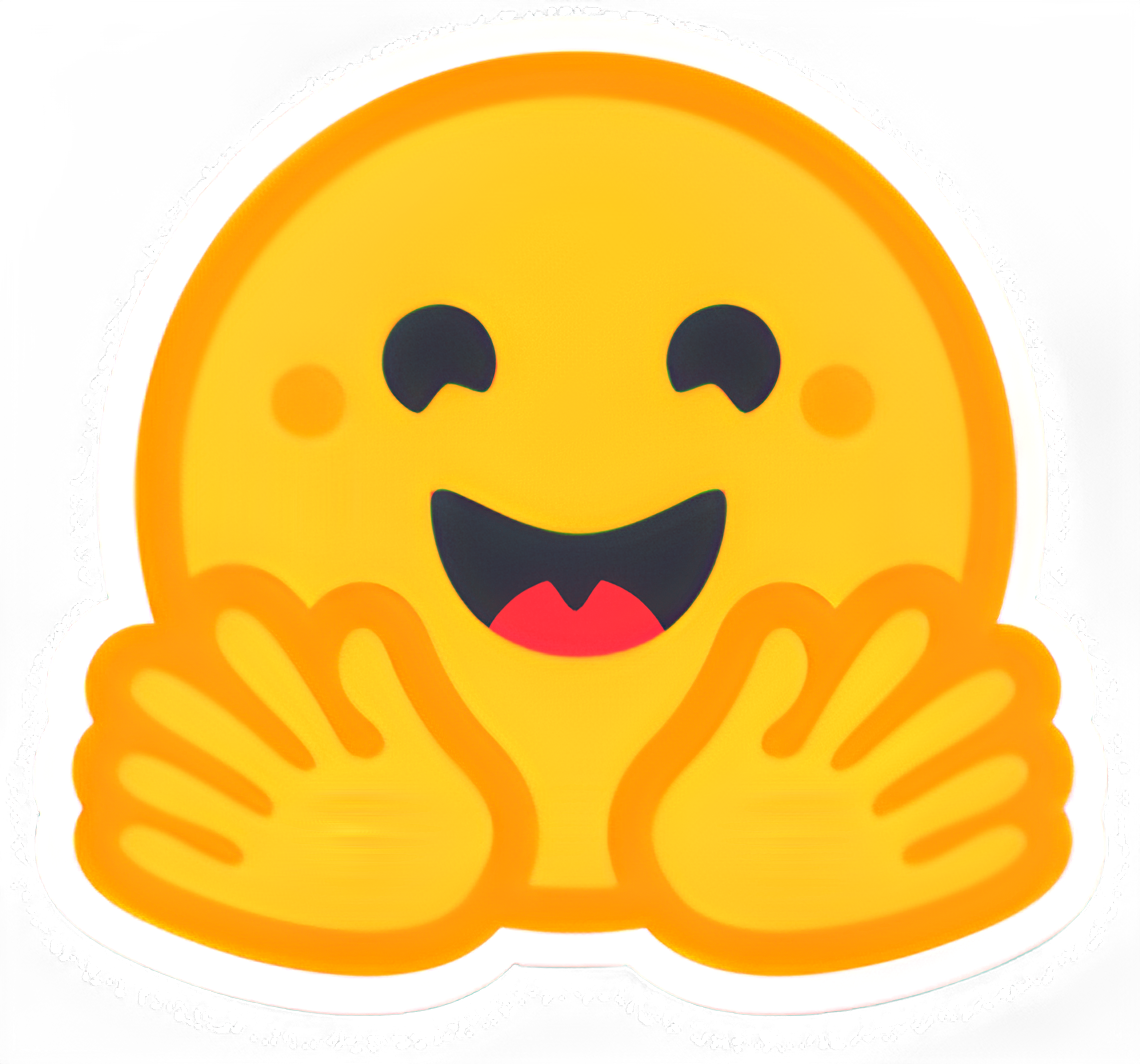

In [78]:
upsampled_image